# Notebook for collection of data + EDA
# James Yu

In [37]:
import pandas as pd
from random import sample
import sys
import json
import time
import altair as alt
import matplotlib.pyplot as plt

In [38]:
#pd.read_csv('../data/dblp-v13/csv/2005.csv', encoding='unicode_escape', lineterminator='\n')

## Looking at arXiv dataset from Kaggle

In [39]:
# arXiv dataset from Kaggle https://www.kaggle.com/neelshah18/arxivdataset
# fp1 = '../data/arxivData.json'
# df1 = pd.read_json(fp1)
# df1.value_counts('year')
# df1.value_counts('month')
# agg_titles_by_year = df1.groupby('year')['title'].apply(' '.join)
# agg_sum_by_year = df1.groupby('year')['summary'].apply(' '.join)
# agg_all_by_year = df1.groupby('year')['title'].apply(' '.join) + ' ' + df1.groupby('year')['summary'].apply(' '.join)

## Looking at DBLP v13 dataset

In [40]:
fp = '../data/dblpv13.json'

In [41]:
# DBLP v13 dataset
# file size is 16.1 GB
# Can try to read in as smaller pieces, or write out the data into .txt files by year
#df2 = pd.read_json(fp2)
#df2.head()
invalid_tags = ['"venue" :', '"_id" :', '"type" :', '"raw" :', '"raw_zh" :',
                '"n_citation" :', '"page_start" :', '"page_end" :',
                '"lang" :', '"volume" :', '"issue" :', '"issn" :',
                '"isbn" :', '"doi" :', '"pdf" :', '"url" :', '"references" :']

In [42]:
# TODO: Create function that gathers value counts of papers by year
# 1. Get # of papers by year
# 2. Get # of papers by year for papers that have formatting issues
# 3. Get most common keywords
# 4. Get most common keywords by year

# TODO: Create a more lightweight function that doesn't store all of the content
#   (maybe just store info on length of title + abstract, year, number of keywords)

In [43]:
def print_stats(time, papers, issues, empty, year):
    print(str(time) + ' seconds has elapsed since start of function')
    print(str(papers) + ' papers processed')
    print(str(issues) + ' number of papers with json formatting issues')
    print(str(empty) + ' number of papers with empty abstracts')
    print(str(year) + ' number of papers with invalid/irrelevant years < 1950, > 2022')

In [44]:
def test(inpath):
    start = time.time()
    first_line = True
    tags = ['"title"', '"year"', '"keywords"', '"abstract"', '"fos"']
    valid_tag = True
    skip_paper = False
    num_papers, num_issues, num_abs, num_year = 0, 0, 0, 0

    content = '{'
    # Keeps track of the start of processing a block (individual paper)
    start_ind = False

    # TODO: Keeps track of # of papers by year
    counts = {}
    # TODO: Keeps track of # of papers by year with formatting issues
    issue_counts = {}

    with open(inpath, 'r', encoding='utf-8') as f:
        for line in f:
            # Indicates start of block
            if line == '{ \n':
                start_ind = True

            # Indicates end of block
            if line == '},\n':
                # Doesn't process the first paper (only contains info about structure)
                if first_line:
                    first_line = False
                    content = '{'
                    start_ind = False
                    continue
                # If there is an indicator to skip the paper
                if skip_paper:
                    content = '{'
                    skip_paper = False
                    start_ind = False
                    continue

                # Cleans up formatting of block
                content += '}\n'
                content = content.replace(' :', ':').replace(',', ', ')
                # Prevents issue with additional comma at end of dict
                if content[-4:-2] == ', ':
                    content = content[:-4] + '}\n'
                # Fix for issue with double beginning brackets
                if content[:2] == '{{':
                    content = content[1:]

                num_papers += 1
                try:
                    formatted = json.loads(content)
                    keywords = ' '.join([word.replace(' ', '_') for word in formatted['keywords']])
                    title = formatted['title'].replace(',', '').replace('\n', '').replace('\\', '')
                    abstract = formatted['abstract'].replace(',', '').replace('\n','').replace('\\', '')
                    if len(abstract) == 0:
                        num_abs += 1
                        continue
                    if formatted['year'] < 1950 or formatted['year'] > 2022:
                        num_year += 1
                        continue

                    if formatted['year'] not in counts:
                        counts[formatted['year']] = 0
                    counts[formatted['year']] += 1

                    # Writing out titles + abstracts to aggregated year .txt file
                    fp1 = '../data/dblp-v13/content_' + str(formatted['year']) + '.txt'
                    f1 = open(fp1, 'a')
                    f1.write(title + ' ' + abstract + ' ')
                    f1.close()
                    # Writing out DBLP keywords to aggregated year .txt file
                    fp2 = '../data/dblp-v13/keywords_' + str(formatted['year']) + '.txt'
                    f2 = open(fp2, 'a')
                    f2.write(keywords + ' ')
                    f2.close()
                except:
                    num_issues += 1

                    idx = content.find('"year":')
                    year = content[idx+8:idx+12]
                    try:
                        year = int(year)
                    except:
                        year = 'invalid'
                    if year not in issue_counts:
                        issue_counts[year] = 0
                    issue_counts[year] += 1

                # For testing purposes - printing info + stopping early
                # if num_papers == 100000:
                #     end = time.time()
                #     time_elapsed = end - start
                #     print_stats(time_elapsed, num_papers, num_issues, num_abs, num_year)
                #     return

                # Reset parameters
                start_ind = False
                content = '{'

            # Processes individual lines once we have found the start indicator
            if start_ind:
                line = line.strip()

                # We only care about title, abstract, keywords, year, fos tags
                if any([tag in line for tag in tags]):
                    valid_tag = True
                elif ' : ' in line:
                    # Catches invalid tags
                    valid_tag = False
                elif '.fr' in line:
                    # Had issues with french papers being included
                    skip_paper = True

                if not valid_tag:
                    continue

                if 'NumberInt' in line:
                    line = line.replace('NumberInt(', '')
                    line = line.strip()[:-2] + ','
                if line[-3:] == ': ,':
                    line = line.replace(': ,', ': null')
                if line == '"type" : 1,':
                    continue
                content += line

    end = time.time()
    time_elapsed = end - start
    #print_stats(time_elapsed, num_papers, num_issues, num_abs, num_year)
    return counts, issue_counts

In [45]:
out = ({2011: 146868,2009: 142125,2001: 49350,2000: 46187,1966: 553,2012: 156854,2002: 59902,2004: 82101,1986: 6080,2010: 142752,2006: 112287,2013: 160375,1961: 252,2003: 67039,2007: 116154,1995: 24356,2005: 95545,1983: 4132,1979: 2973,1996: 27216,1988: 9362,2015: 169413,1977: 2505,1990: 12605,1992: 16528,1975: 2393,1989: 10601,1997: 30217,2008: 126724,1985: 5284,2014: 170577,1998: 34664,1962: 329,1993: 19292,1968: 928,1999: 39722,1984: 4431,1974: 2414,1981: 3596,1972: 1571,1987: 6976,1980: 3203,1982: 3861,1950: 2,1963: 335,1958: 168,1957: 151,1969: 942,1952: 52,1964: 403,1960: 212,1971: 1238,1991: 14574,1994: 22733,2017: 110687,1970: 1017,1953: 46,1976: 2522,2016: 104869,1959: 244,1973: 1902,1978: 2779,1967: 690,2018: 143727,1955: 75,1965: 415,2019: 133736,1956: 133,1951: 35,1954: 79,2020: 110836,2021: 6205},{1993: 14033,2007: 38942,2009: 42113,2004: 29079,1980: 3103,1962: 612,2002: 21576,1957: 153,1917: 1,2012: 62923,2011: 58907,1983: 4708,2013: 73501,2006: 35653,1971: 1169,2000: 20306,2014: 71119,2003: 25892,1988: 8112,2008: 41112,1989: 9443,1961: 405,1997: 16890,1998: 18382,1999: 20206,2005: 33676,2001: 21900,1982: 4045,2010: 50340,1948: 32,1992: 12474,2015: 81428,1996: 15336,1986: 7243,1994: 14639,1990: 10614,1930: 5,1969: 761,2017: 201453,1995: 15057,1977: 2248,1975: 1656,1950: 29,1987: 7357,1981: 3433,1968: 837,1903: 5,1979: 2485,1984: 5488,1946: 29,1970: 790,1931: 8,1958: 209,1976: 1985,1945: 13,1942: 16,1991: 11508,1959: 356,1972: 1323,1966: 626,1926: 5,1935: 3,1985: 5641,1927: 4,1922: 8,1941: 13,1924: 5,1938: 15,1939: 22,1964: 399,'invalid': 508,1937: 16,1963: 443,1952: 55,1928: 5,1936: 16,1940: 17,1918: 3,1874: 1,1949: 47,1965: 519,1978: 2660,1967: 635,1898: 4,1953: 80,1944: 10,1947: 21,1974: 1525,1934: 3,1907: 3,1929: 3,1932: 13,1919: 4,1955: 103,2018: 217065,1951: 27,1956: 145,1973: 1486,1911: 4,1954: 111,1925: 4,1901: 2,1920: 3,2016: 172503,1905: 3,1912: 6,1916: 2,2019: 222526,1921: 1,1960: 260,1923: 3,1943: 14,1914: 5,2300: 10,1908: 2,1860: 1,2020: 227877,1881: 1,9737: 1,1878: 1,1913: 3,1933: 5,1891: 1,1909: 2,1894: 4,1876: 1,1892: 1,8509: 1,1852: 1,1885: 1,1850: 1,1900: 2,1902: 2,1904: 1,1831: 1,1910: 3,1843: 1,1815: 1,1824: 1,1849: 1,1800: 1,1906: 2,1855: 1,1872: 1,1896: 1,1887: 1,1899: 3,1915: 1,1895: 1,1877: 1,1883: 1,2021: 47168,2022: 1})

In [46]:
actual = pd.DataFrame(pd.Series(out[0]).astype(int)).reset_index().rename(columns={'index': 'Year', 0: 'Count'})
actual.sort_values(by='Year', inplace=True, ignore_index=True)
actual

,Year,Count
0,1950,2
1,1951,35
2,1952,52
3,1953,46
4,1954,79
...,...,...
67,2017,110687
68,2018,143727
69,2019,133736
70,2020,110836


In [47]:
errors = pd.DataFrame(pd.Series(out[1]).astype(int)).reset_index().rename(columns={'index': 'Year', 0: 'Count'})
idx = 153
for year in range(1950, 2022):
    if year not in errors['Year'].values:
        errors.loc[idx] = [year, 0]
        idx += 1
errors['Year'] = errors['Year'].replace({'invalid': 0})
errors.sort_values(by='Year', inplace=True, ignore_index=True)
errors

,Year,Count
0,0,508
1,1800,1
2,1815,1
3,1824,1
4,1831,1
...,...,...
148,2021,47168
149,2022,1
150,2300,10
151,8509,1


In [48]:
alt.Chart(actual, title='# of papers per year').mark_bar().encode(x='Year', y='Count', tooltip=['Year', 'Count']).interactive()

alt.Chart(...)

In [49]:
alt.Chart(errors, title='# of papers (with json errors) per year').mark_bar().encode(x='Year', y='Count', tooltip=['Year', 'Count']).interactive()

alt.Chart(...)

# Look at DBLP v10 dataset

In [50]:
infolder = '../data/dblp-v10'
filepaths = [infolder + '/dblp-ref-' + str(num) + '.json' for num in range(4)]

In [51]:
counts = {}

In [52]:
# for fp in filepaths:
#     file = open(fp)
#     for line in file:
#         try:
#             data = json.loads(line)
#             year = data['year']
#             if year < 1950 or year > 2018:
#                 continue
#             if 'abstract' in data.keys():
#                 if len(data['abstract']) == 0:
#                     continue
#             else:
#                 continue
#             if 'title' in data.keys():
#                 pass
#             else:
#                 continue
#             if year not in counts:
#                 counts[year] = 0
#             else:
#                 counts[year] += 1
#         except:
#             num_issues += 1
#     file.close()

In [53]:
# v10_counts = pd.DataFrame.from_dict(counts, orient='index').reset_index().rename(columns={'index': 'Year', 0: 'Count'})
# v10_counts.sort_values(by='Year', inplace=True, ignore_index=True)
# v10_counts

In [54]:
fp_v10 = '../data/dblp-v10/dblp-v10-counts.csv'

In [55]:
v10_counts = pd.read_csv(fp_v10, index_col=0)
v10_counts

,Year,Count
0,1950,1
1,1951,1
2,1952,6
3,1953,20
4,1954,41
...,...,...
64,2014,169247
65,2015,188142
66,2016,185341
67,2017,56551


In [56]:
# Altair examples: https://altair-viz.github.io/gallery/index.html
x = alt.Chart(v10_counts, title='# of papers per year').mark_bar().encode(x='Year', y='Count', tooltip=['Year', 'Count']).interactive()
x

alt.Chart(...)

Text(0.5, 1.0, 'Number of papers per year (DBLP v10)')

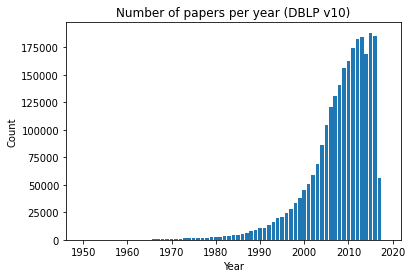

In [57]:
plt.bar(v10_counts['Year'], v10_counts['Count'])
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Number of papers per year (DBLP v10)')
#plt.savefig('test.png')

In [58]:
#from altair_saver import save
#save(x, 'test.png')

# Looking at AutoPhrase and segmentation results

In [59]:
ap_fp = '../results/dblp-v10-grouped/phrases.csv'

In [60]:
ap = pd.read_csv(ap_fp, index_col=0)
ap.head()

,Phrase Quality,Phrase,Year,Num Words
0,0.9915,operations research,1950-1959,2
1,0.6505,operations research society of america,1950-1959,5
2,0.5735,high speed,1950-1959,2
3,0.5255,operations research society,1950-1959,3
4,0.9810,tunnel diode,1960-1964,2


In [61]:
avg_num_words = ap.groupby('Year')['Num Words']
avg_num_words.mean()

Year
1950-1959    3.000000
1960-1964    2.000000
1965-1969    2.050000
1970-1974    2.082707
1975-1979    2.118812
1980-1984    2.085992
1985-1989    2.123845
1990-1994    2.138755
1995-1999    2.080498
2000-2004    2.114116
2005-2009    2.142949
2010-2014    2.154896
2015-2017    2.112137
Name: Num Words, dtype: float64

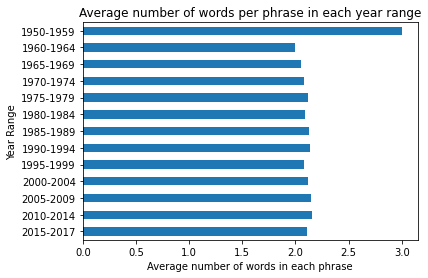

In [62]:
avg_num_words.mean().plot(kind='barh', 
                          xlabel='Year Range', 
                          title='Average number of words per phrase in each year range')
plt.xlabel('Average number of words in each phrase')
plt.gca().invert_yaxis()

Text(0.5, 0, 'Number of words in phrase')

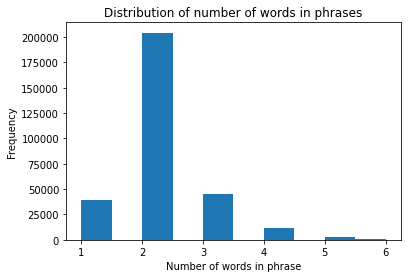

In [63]:
ap['Num Words'].plot.hist(title='Distribution of number of words in phrases')
plt.xlabel('Number of words in phrase')

In [64]:
from glob import glob

In [65]:
infolder = '../results/dblp-v10-grouped'
subfolders = glob(infolder + '/*.csv')
subfolders = list(filter(lambda x: 'segmented' in x, subfolders))

In [66]:
out = pd.DataFrame(columns=['Year', 'Num Phrases'])
for fp in subfolders:
    df = pd.read_csv(fp, index_col=0)
    df = df.dropna()
    df['Num Phrases'] = df.apply(lambda x: len(x['Phrases'].split(',')), axis=1)
    #df = df.drop('Phrases', axis=1)
    out = out.append(df, ignore_index=True)

In [67]:
out

,Year,Num Phrases,Phrases
0,1950-1959,14,"paper,wheatstone,bridge,tangent,triangle,trian..."
1,1950-1959,6,"numerical integration,differential equations,o..."
2,1950-1959,1,fur
3,1950-1959,8,"computing,computing,amplifier,high,amplifiers,..."
4,1950-1959,5,"operations research,journal,operations researc..."
...,...,...,...
2548126,2015-2017,44,"research,fi,indoor,location-based service lbs,..."
2548127,2015-2017,18,"icts,eliminating,gender,entrepreneurship,gover..."
2548128,2015-2017,12,"infinite horizon,inventory,model,general,reven..."
2548129,2015-2017,51,"infrared,technology,deep-space,radiation,earth..."


In [68]:
out.groupby('Year')['Num Phrases'].mean()

Year
1950-1959    13.215569
1960-1964    12.715123
1965-1969    11.686223
1970-1974    10.842989
1975-1979    11.825850
1980-1984    12.377227
1985-1989    14.123148
1990-1994    15.992997
1995-1999    18.931781
2000-2004    21.217220
2005-2009    30.345482
2010-2014    37.662749
2015-2017    32.390009
Name: Num Phrases, dtype: float64

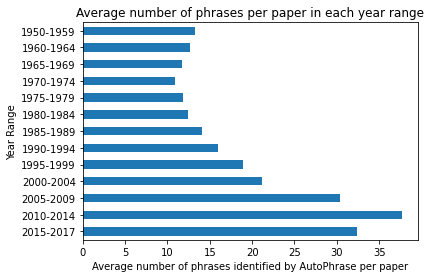

In [69]:
out.groupby('Year')['Num Phrases'].mean().plot(kind='barh', 
                                               xlabel='Year Range',
                                               title='Average number of phrases per paper in each year range')
plt.xlabel('Average number of phrases identified by AutoPhrase per paper')
plt.gca().invert_yaxis()

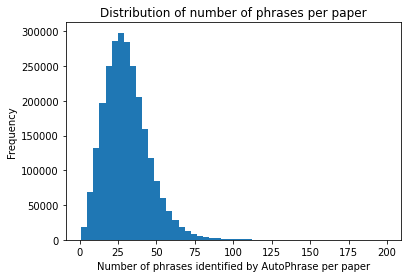

In [73]:
out[out['Num Phrases'] < 200]['Num Phrases'].plot.hist(bins=50, title='Distribution of number of phrases per paper')
plt.xlabel('Number of phrases identified by AutoPhrase per paper')
plt.autoscale()

In [71]:
#out['Num Phrases'].plot.hist(bins=50, title='Distribution of number of phrases per paper')

In [72]:
sort_out = out['Num Phrases'].sort_values()
sort_out[-20:]

1537086    322
1562036    327
729979     329
144075     329
1925705    331
1830399    339
2282915    339
1551934    340
1514717    340
1511660    341
1499203    343
1520344    347
1694641    349
1630115    349
783170     350
2070142    355
1320528    357
1328105    371
714968     374
664871     689
Name: Num Phrases, dtype: object